# Построение моделей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from tqdm import tqdm
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.options.display.max_columns = 50

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, precision_recall_curve

In [3]:
def plot_pr_curve(y_true, prediction):
    precision, recall, thresholds = precision_recall_curve(y_true, prediction)
    thresholds = [0] + thresholds.tolist()
    plt.plot(thresholds, precision, label='precision');
    plt.plot(thresholds, recall, label='recall');
    plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Precision or recall');
    plt.title('Precision and recall for unbalanced dataset');

In [4]:
%%time
flights = pd.read_csv('v3/dep_delay_df.csv')
flights.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
#flights.FIRST_DEP_TIME.fillna(0, inplace=True)
#flights.TOTAL_ADD_GTIME.fillna(0, inplace=True)
#df.LONGEST_ADD_GTIME.fillna(0, inplace=True)
flights.drop('LONGEST_ADD_GTIME', axis=1, inplace=True)
flights.drop('TOTAL_ADD_GTIME', axis=1, inplace=True)
flights.drop('FIRST_DEP_TIME', axis=1, inplace=True)
flights.STD_DELAY.fillna(0, inplace=True)
flights.MEAN_DELAY.fillna(0, inplace=True)
flights.MAX_DELAY.fillna(0, inplace=True)
flights.MIN_DELAY.fillna(0, inplace=True)
flights.COUNT.fillna(0, inplace=True)
flights['25%_DELAY'].fillna(0, inplace=True)
flights['50%_DELAY'].fillna(0, inplace=True)
flights['75%_DELAY'].fillna(0, inplace=True)
flights.dropna(inplace=True)

CPU times: user 38 s, sys: 16.1 s, total: 54 s
Wall time: 58 s


## Прогнозирование DEPARTURE_DELAY

In [5]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4738774 entries, 0 to 5714007
Data columns (total 51 columns):
 #   Column              Dtype  
---  ------              -----  
 0   MONTH               int64  
 1   DAY                 int64  
 2   DAY_OF_WEEK         int64  
 3   AIRLINE             int64  
 4   TAIL_NUM            int64  
 5   FLIGHT_MUNBER       int64  
 6   ORIGIN              int64  
 7   ORIGIN_CITY_NAME    int64  
 8   DEST                int64  
 9   DEST_CITY_NAME      int64  
 10  CRS_DEP_TIME        int64  
 11  DEP_DELAY           float64
 12  CRS_ARR_TIME        int64  
 13  DISTANCE            float64
 14  maxtempC            int64  
 15  mintempC            int64  
 16  totalSnow_cm        float64
 17  sunHour             float64
 18  uvIndex             int64  
 19  moon_illumination   int64  
 20  tempC               int64  
 21  windspeedKmph       int64  
 22  winddirDegree       int64  
 23  weatherCode_origin  float64
 24  precipMM            floa

In [6]:
flights.shape

(4738774, 51)

In [7]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DISTANCE,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,tempC,windspeedKmph,winddirDegree,weatherCode_origin,precipMM,...,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,weatherCode_dest,COUNT,MEAN_DELAY,STD_DELAY,MIN_DELAY,25%_DELAY,50%_DELAY,75%_DELAY,MAX_DELAY,WEEKEND,LATE_AIRLINE_INDEX,LATE_TAIL_INDEX,LATE_ARR,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4
0,4,23,4,619639,108773,165,640831,323905,795909,376956,1210,-8.0,1414,1440.0,8,3,0.0,13.8,3,29,8,12,324,113.0,0.0,...,10,1018,23,8,-1,5,17,5,200.0,10.0,-1.600000,8.408990,-11.0,-5.5,-3.0,-0.50,20.0,0,0.119103,0.108824,0.0,0.0,0.0,0.0,0.0
1,4,24,5,619639,246721,165,640831,323905,795909,376956,1210,4.0,1414,1440.0,11,3,0.0,12.2,3,36,11,13,90,116.0,0.0,...,10,1017,46,11,-1,10,22,10,176.0,19.0,22.157895,49.944706,-9.0,-3.0,-1.0,12.00,140.0,0,0.119103,0.123330,0.0,1.0,1.0,0.0,0.0
2,4,25,6,619639,840720,165,640831,323905,795909,376956,1210,44.0,1414,1440.0,7,4,0.0,9.8,2,44,5,14,60,122.0,0.0,...,10,1009,100,5,4,2,22,2,113.0,11.0,1.636364,16.698938,-7.0,-5.5,-4.0,-0.50,51.0,1,0.119103,0.136511,0.0,0.0,1.0,0.0,0.0
3,4,26,7,619639,39014,165,640831,323905,795909,376956,1210,-5.0,1414,1440.0,8,3,0.0,13.9,3,52,8,17,15,113.0,0.0,...,10,1017,3,8,2,6,23,6,116.0,22.0,17.272727,37.386249,-8.0,-4.0,-1.5,15.50,128.0,1,0.119103,0.110572,0.0,0.0,1.0,1.0,0.0
4,4,27,1,619639,854242,165,640831,323905,795909,376956,1210,9.0,1414,1440.0,7,3,0.0,13.9,3,59,7,27,13,113.0,0.0,...,10,1021,14,7,3,3,39,3,113.0,18.0,8.333333,26.648033,-6.0,-4.0,-2.5,2.25,94.0,0,0.119103,0.119418,1.0,1.0,1.0,0.0,0.0


In [8]:
def fill_dep_delay(x):
    if x >= 15:
        return 1
    return 0

In [9]:
flights['DEP_DELAY'] = flights['DEP_DELAY'].apply(fill_dep_delay)

In [10]:
scaler = StandardScaler()

In [11]:
y = flights.DEP_DELAY
flights.drop('DEP_DELAY', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(flights, y, random_state=42, stratify=y)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Линейные модели регрессии

Главное преимущество линейных моделей в том, что они быстро обучаются даже на большой выборке. Это решение можно смело назвать базовым для широкого спектра задач, которое позволяет получить неплохой ответ уже на старте. 

Lasso регрессия вряд ли даст лучший результат, так как у нас нет большого количества мультиколлинеарных значений. По той же причине не стоит ожидать прорыва от Ridge и ElasticNet. Но мы всё же это проверим.

In [11]:
from sklearn.linear_model import LogisticRegression

In [13]:
%%time
logit = LogisticRegression(max_iter=200)
logit.fit(x_train, y_train)
print(classification_report(y_test, logit.predict(x_test)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    968346
           1       0.69      0.40      0.51    216348

    accuracy                           0.86   1184694
   macro avg       0.79      0.68      0.71   1184694
weighted avg       0.84      0.86      0.84   1184694

CPU times: user 57 s, sys: 1.08 s, total: 58.1 s
Wall time: 1min


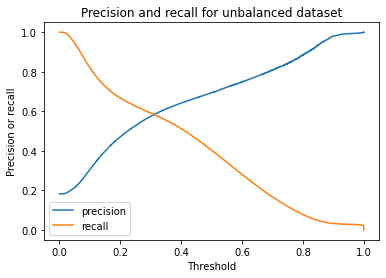

In [17]:
plot_pr_curve(y_test, logit.predict_proba(x_test)[:,1])

### Сбалансированные веса

In [20]:
%%time
logit = LogisticRegression(class_weight='balanced', max_iter=200)
logit.fit(x_train, y_train)
print(classification_report(y_test, logit.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86    968346
           1       0.45      0.69      0.54    216348

    accuracy                           0.79   1184694
   macro avg       0.68      0.75      0.70   1184694
weighted avg       0.83      0.79      0.80   1184694

CPU times: user 1min 12s, sys: 408 ms, total: 1min 12s
Wall time: 1min 13s


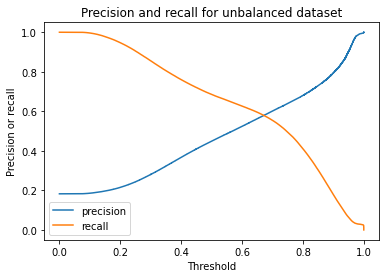

In [22]:
plot_pr_curve(y_test, logit.predict_proba(x_test)[:,1])

### Нейросетевая регрессия

In [15]:
from keras.models import Sequential
from keras.layers import Dense, ReLU

In [17]:
network = Sequential()
network.add(Dense(32, input_dim=x_train.shape[1], kernel_initializer='he_normal', activation='relu'))
network.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
#network.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

network.compile(optimizer="rmsprop", loss="binary_crossentropy")

In [19]:
%%time
network.fit(x_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3559
Epoch 2/10
13884/13884 [==============================] - 27s 2ms/step - loss: 0.3552
Epoch 3/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3547
Epoch 4/10
13884/13884 [==============================] - 27s 2ms/step - loss: 0.3543
Epoch 5/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3540
Epoch 6/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3538
Epoch 7/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3535
Epoch 8/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3534
Epoch 9/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3534
Epoch 10/10
13884/13884 [==============================] - 28s 2ms/step - loss: 0.3533
CPU times: user 8min 36s, sys: 45.3 s, total: 9min 21s
Wall time: 4min 42s


In [20]:
p_network = network.predict(x_test)

In [23]:
def threshhold(x):
    if x >= 0.5:
        return 1
    return 0

In [24]:
test_score = []
for i in tqdm(range(len(y_test))):
    test_score.append(threshhold(p_network[i]))

print(classification_report(y_test, test_score))

100%|██████████| 1184694/1184694 [00:04<00:00, 272745.52it/s]


              precision    recall  f1-score   support

           0       0.88      0.96      0.92    968346
           1       0.71      0.43      0.53    216348

    accuracy                           0.86   1184694
   macro avg       0.79      0.69      0.73   1184694
weighted avg       0.85      0.86      0.85   1184694



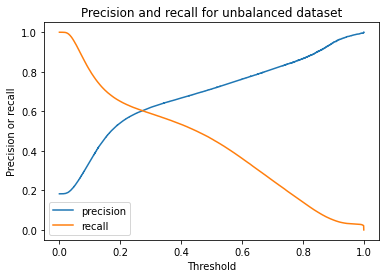

In [40]:
plot_pr_curve(y_test, p_network)

### Метод опорных векторов

In [12]:
from sklearn.svm import LinearSVC

In [ ]:
%%time
svc = LinearSVC()
svc.fit(x_train, y_train)

In [ ]:
print(classification_report(y_test, svc.predict(x_test)))

### K-ближайщих соседей

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
%%time
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=6)
knn.fit(x_train, y_train)

In [107]:
#%%script False
prediction = knn.predict(x_test)

17.408651338472527

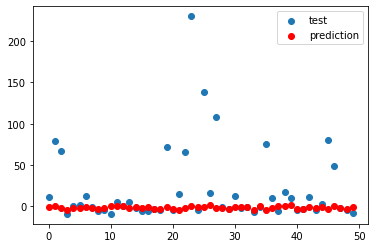

In [12]:
print(classification_report(y_test, prediction))

### Дерево решений

Достаточно непростой алгоритм с точки зрения подбора гиперпараметров. Ограничим количество признаков и его максимальную глубину

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
%%time
tree = DecisionTreeClassifier(max_depth=10, max_features=13, random_state=42)
tree.fit(x_train, y_train)

CPU times: user 1min 13s, sys: 344 ms, total: 1min 14s
Wall time: 1min 14s


DecisionTreeClassifier(max_depth=10, max_features=13, random_state=42)

In [16]:
print(classification_report(y_test, tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    968346
           1       0.68      0.49      0.57    216348

    accuracy                           0.86   1184694
   macro avg       0.79      0.72      0.74   1184694
weighted avg       0.85      0.86      0.86   1184694



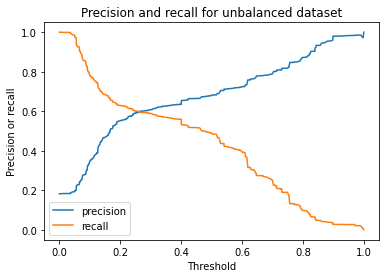

In [17]:
plot_pr_curve(y_test, tree.predict_proba(x_test)[:, 1])

Неплохой результат. Сохраним получившееся дерево

In [135]:
from sklearn.tree import export_graphviz

In [136]:
# для этого понадобится библиотека pydot, graphviz (pip3 install pydot graphviz)
export_graphviz(tree, feature_names=X.columns, out_file='tree.dot', filled=True)
# !dot -Tpng 'tree.dot' -o 'tree.png'

### Ансамблевые модели

Начнём со случайного леса. Ограничим количество деревьев, глубину, набор признаков для сокращения времени обучения

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
%%time
forest = RandomForestClassifier(n_estimators=20, max_depth=10, max_features=10, verbose=True, n_jobs=6, random_state=42)
forest.fit(x_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


CPU times: user 14min 59s, sys: 7.2 s, total: 15min 6s
Wall time: 3min 1s


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  3.0min finished


RandomForestClassifier(max_depth=10, max_features=10, n_estimators=20, n_jobs=6,
                       random_state=42, verbose=True)

In [23]:
print(classification_report(y_test, forest.predict(x_test)))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.1s finished


              precision    recall  f1-score   support

           0       0.88      0.96      0.92    968346
           1       0.72      0.43      0.54    216348

    accuracy                           0.87   1184694
   macro avg       0.80      0.70      0.73   1184694
weighted avg       0.85      0.87      0.85   1184694



[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.0s finished


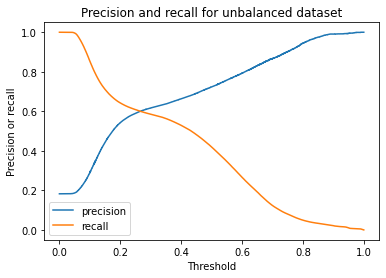

In [20]:
plot_pr_curve(y_test, forest.predict_proba(x_test)[:, 1])

Попробуем увеличить число деревьев

In [13]:
%%time
forest = RandomForestClassifier(n_estimators=100, verbose=True, n_jobs=6, random_state=42)
forest.fit(x_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.0min


CPU times: user 1h 39min 32s, sys: 27.1 s, total: 1h 39min 59s
Wall time: 17min 3s


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 17.0min finished


RandomForestClassifier(n_jobs=6, random_state=42, verbose=True)

In [14]:
print(classification_report(y_test, forest.predict(x_test)))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   55.4s finished


              precision    recall  f1-score   support

           0       0.89      0.96      0.92    968346
           1       0.71      0.45      0.55    216348

    accuracy                           0.87   1184694
   macro avg       0.80      0.71      0.74   1184694
weighted avg       0.85      0.87      0.85   1184694



Есть небольшая надежда в уменьшении ошибки за счёт усложнения модели, что приведёт к существенному увеличению времени. Решением этой проблемы мы займемся позже.

Испытаем градиентный бустинг

In [12]:
from xgboost import XGBClassifier

In [13]:
%%time
grad = XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
grad.fit(x_train, y_train)

/home/max/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1h 39min 9s, sys: 21.9 s, total: 1h 39min 31s
Wall time: 16min 42s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
print(classification_report(y_test, grad.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    968346
           1       0.70      0.47      0.56    216348

    accuracy                           0.87   1184694
   macro avg       0.80      0.71      0.74   1184694
weighted avg       0.85      0.87      0.86   1184694



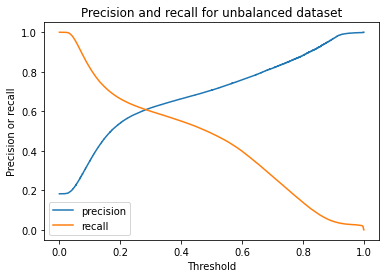

In [34]:
plot_pr_curve(y_test, grad.predict_proba(x_test)[:, 1])

По умолчанию глубина деревьев не больше пяти, а число признаков - произвольное. Вероятно, что усложнение модели улучшит текущий результат

## Модель для одной авиалинии и всех аэропортов

In [3]:
%%time
flights = pd.read_csv('v3/dep_delay_df.csv')
flights.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
#flights.FIRST_DEP_TIME.fillna(0, inplace=True)
#flights.TOTAL_ADD_GTIME.fillna(0, inplace=True)
#df.LONGEST_ADD_GTIME.fillna(0, inplace=True)
flights.drop('LONGEST_ADD_GTIME', axis=1, inplace=True)
flights.drop('TOTAL_ADD_GTIME', axis=1, inplace=True)
flights.drop('FIRST_DEP_TIME', axis=1, inplace=True)
flights.STD_DELAY.fillna(0, inplace=True)
flights.MEAN_DELAY.fillna(0, inplace=True)
flights.MAX_DELAY.fillna(0, inplace=True)
flights.MIN_DELAY.fillna(0, inplace=True)
flights.COUNT.fillna(0, inplace=True)
flights['25%_DELAY'].fillna(0, inplace=True)
flights['50%_DELAY'].fillna(0, inplace=True)
flights['75%_DELAY'].fillna(0, inplace=True)
flights.dropna(inplace=True)

CPU times: user 33.3 s, sys: 7.83 s, total: 41.2 s
Wall time: 42.4 s


In [8]:
flights['DEP_DELAY'] = flights['DEP_DELAY'].apply(fill_dep_delay)

In [17]:
flights.AIRLINE.value_counts()

405545    1040313
746972     759461
301074     587621
217754     510081
650940     488886
864772     417377
6004       260328
602088     185924
434        158780
993966     157382
121797      65643
164258      59318
222509      47660
Name: AIRLINE, dtype: int64

In [18]:
df = flights[flights.AIRLINE == 864772].copy()
df.drop('AIRLINE', axis=1, inplace=True)

In [19]:
X = df.drop('DEP_DELAY', axis=1)
y = df.DEP_DELAY
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [20]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_f1 = f1_score(y_test, model_pred)
    
    # Return the performance metric
    return model_f1

По традиции начнем с линейной регрессии

In [22]:
%%time
logit = LogisticRegression(max_iter=200)
logit_f1 = fit_and_evaluate(logit)
print('Logistc Regression Performance on the test set: F1 = %0.4f' % logit_f1)

Logistc Regression Performance on the test set: F1 = 0.4916
CPU times: user 8.52 s, sys: 3.27 ms, total: 8.52 s
Wall time: 8.54 s


Посмотрим на дерево решений

In [23]:
%%time
tree = DecisionTreeClassifier(max_depth=10, max_features=13, random_state=42)
tree_f1 = fit_and_evaluate(tree)
print('DecisionTreeRegressor Performance on the test set: F1 = %0.4f' % tree_f1)

DecisionTreeRegressor Performance on the test set: F1 = 0.5336
CPU times: user 3.3 s, sys: 20.6 ms, total: 3.32 s
Wall time: 3.37 s


Случайный лес

In [24]:
%%time
forest = RandomForestClassifier(n_estimators=50, n_jobs=6, max_depth=7, max_features=10, random_state=42)
forest_f1 = fit_and_evaluate(forest)
print('Random Forest Regression Performance on the test set: F1 = %0.4f' % forest_f1)

Random Forest Regression Performance on the test set: F1 = 0.5167
CPU times: user 1min 44s, sys: 981 ms, total: 1min 45s
Wall time: 18.5 s


Градиентный бустинг

In [25]:
%%time
gradient = XGBClassifier(n_estimators=100, n_jobs=6, random_state=42, use_label_encoder=False)
gradient_f1 = fit_and_evaluate(gradient)
print('Gradient Boosted Regression Performance on the test set: F1 = %0.4f' % gradient_f1)

[21:51:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Gradient Boosted Regression Performance on the test set: F1 = 0.5601
CPU times: user 3min 27s, sys: 1.14 s, total: 3min 28s
Wall time: 35.9 s


Метод опорных векторов

In [26]:
%%time
svc = LinearSVC()
svc_f1 = fit_and_evaluate(svc)
print('LinearSVC Performance on the test set: F1 = %0.4f' % svc_f1)

LinearSVC Performance on the test set: F1 = 0.4771
CPU times: user 5min 19s, sys: 85.1 ms, total: 5min 19s
Wall time: 5min 19s


/home/max/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


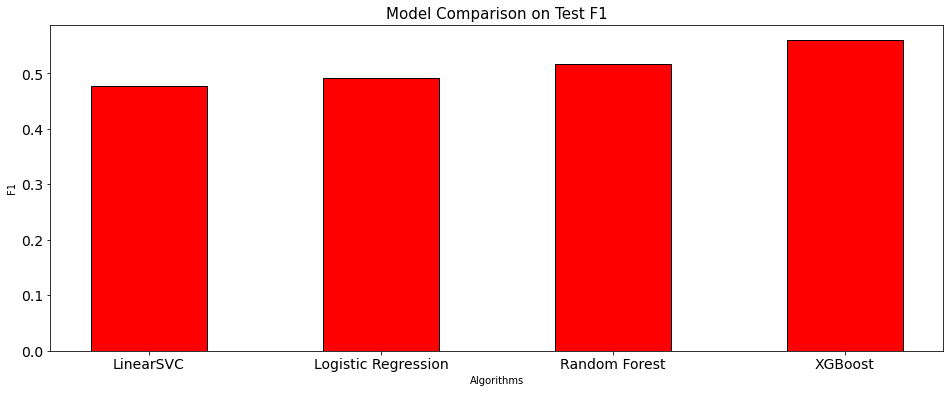

In [27]:
#plt.style.use('fivethirtyeight')
# Dataframe to hold the results
plt.figure(figsize=(16,6))
model_comparison = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest', 'XGBoost',
                                            'LinearSVC'],
                                 'f1': [logit_f1, forest_f1, gradient_f1, svc_f1]})

# Horizontal bar chart of test mae
model_comparison = model_comparison.sort_values('f1', ascending = True)
plt.bar(model_comparison['model'], model_comparison['f1'], color = 'red', edgecolor = 'black', width=0.5)

# Plot formatting
plt.ylabel('F1'); plt.yticks(size = 14); plt.xlabel('Algorithms'); plt.xticks(size = 14)
plt.title('Model Comparison on Test F1', size = 15);

## Анализ результатов

В ходе данной части были построены основные модели регрессий для предсказания задержки вылета. В среднем, все модели показывают одинаковый результат: средняя абсолютная ошибка находится в районе 13 минут. Что касается времени обучения, то тут не всё так однозначно. 

Рекордсменом по времени обучения стала линейная регрессия. За ней же идут и её регуляризованные аналоги. Также удачным оказался метод опорных векторов и нейросетевая регрессия. Ансамблевые модели имеют традиционно медленное время обучения на большой выборке, но являются чуть ли не универсальным средством для многих задач. 

Плохо показал себя алгоритм К-ближайших соседей. Во-первых, качество самое худшее. Во-вторых неприемлемо большое время для обучения и построения прогноза. От этого алгоритма мы однозначно откажемся.

В последующей части мы проведём более точную настройку для каждого из следующих методов:
- Линейная регрессия
- Метод опорных векторов
- Градиентный бустинг
- Нейросетевая регрессия

Удачным оказался подход в разделении выборки на отдельные авиалинии. Это позволило получить чуть лучшее качество и сократить время обучения. Данный подход оправдан не только большим объёмом выборки, но и значительным количеством аномально долгих задержек.